# Boost your grasp on boosting

Demystifying the famous competition-winning algorithm.

The popularization of boosting has been a major breakthrough in applied machine learning. Inherently easy to implement thanks to multiple software packages while achieving high performance on many tasks, boosting has become a default go-to approach for many. It has been used in industry to build valuable products and by Kaggle grandmasters to win competitions. In this article, we will look at boosting in detail.

Read on to see:
* That although initially intimidating, boosting is in fact easy to understand. 
* That you can implement different boosting flavors yourself in just a couple of lines of code.
* What makes a good weak learner to be boosted and why trees are a common choice.
* The difference between adaptive and gradient boosting.
* What knobs can you tune to optimize boosting algorithms.

# What is boosting?

Boosting is an ensemble technique that aggregates a number of sequentially fitted simple models called "weak learners" into a single one, the "strong learner". At its heart, boosted prediction is simply a weighted average of weak learners' predictions, such that:
1. Better weak learners receive larger weights,
2. When fitted, each weak learner prioritizes observations misspredicted by the previous one, thereby focusing on the most difficult cases.

It is as simple as that.

Particular boosting algorithms, such as adaptive or gradient boosting that we will talk about shortly, mainly differ in how the weak learner's weights are calculated and how do they prioritize the most difficult observations.

# Adaptive Boosting

To put things into practical perspective, let's look at the first boosting algorithm, historically speaking. Adaptive Boosting, also known as AdaBoost, was proposed in 1997 already. It was initially designed for classification tasks and only later extended to regression settings. For more focus, we will analyze the classification case. 

AdaBoost's idea is to fit weak learners using sample weights. We start with each observation having the same weight, and as the consecutive weak learners are built, the observation weights get updated to put more emphasis on difficult cases. The schema below outlines what happens within a single adaptive boosting iteration. Hopefully, it will drive the point home.

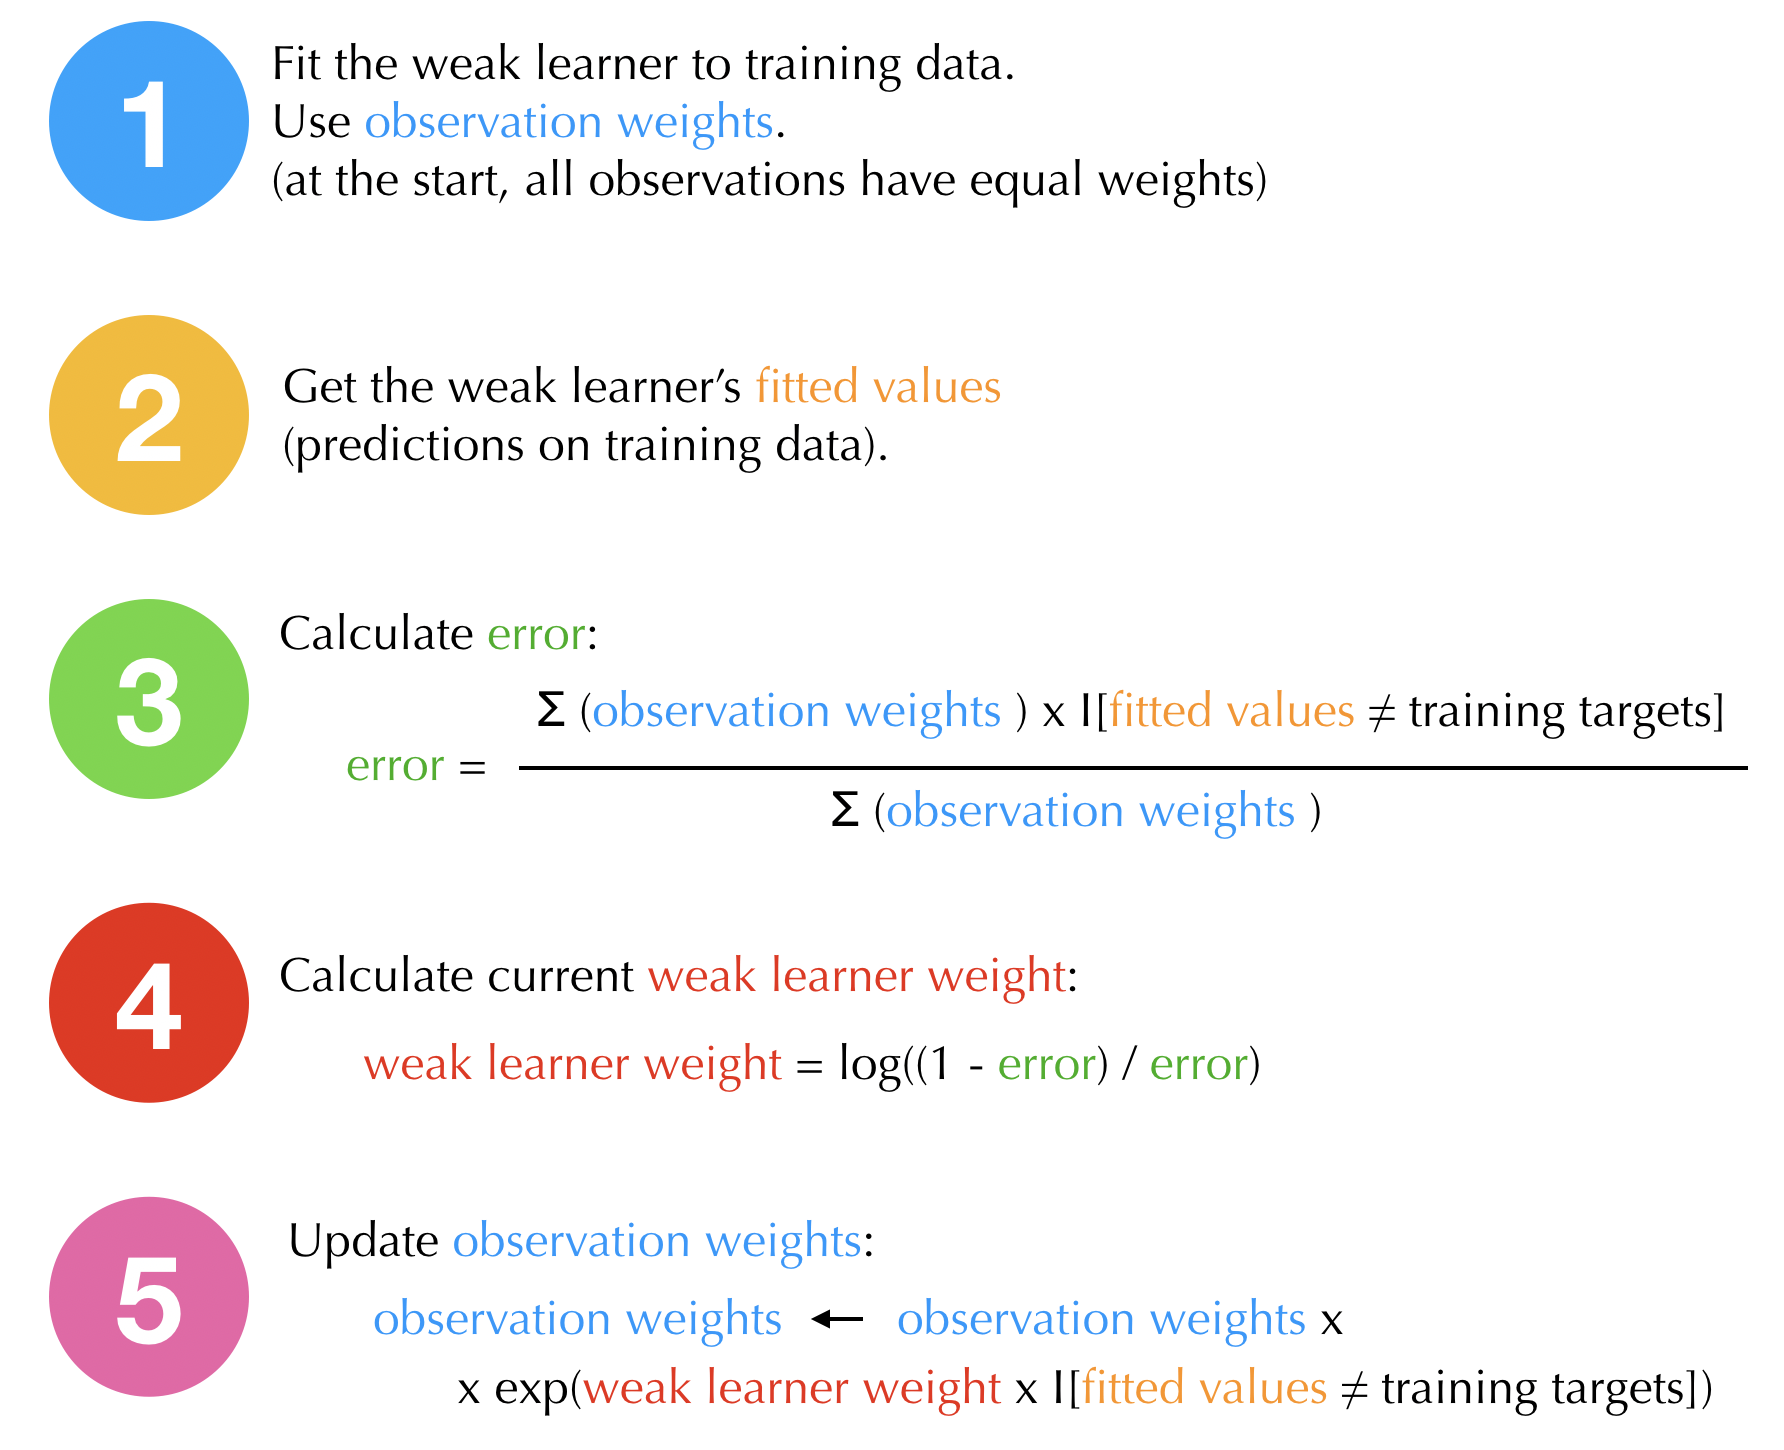

In [315]:
Image(filename='adaboost_pic.png', width=700) 

Once the desired number of weak learners are fit, the final predictions can be obtained by simply averaging their predictions weighted by the respective model weights. 

Let's code it ourselves! Our weak learners will be simple decision trees, and we will apply AdaBoost to the spam data set, in which the task is to classify emails as either spam or not spam based on a set of features describing word frequencies used in the emails. The data, as well as the code to load and process it, are available [here](https://github.com/MichalOleszak/KnowledgeBank/tree/master/blog_posts/boosting/boosting.ipynb). For now, you just need to know we have a binary target $y$ coded as 1 for spam and -1 for non-spam, and a set of features $X$, and 25% of the data has been put aside as a test set.

In [252]:
from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score

spam_data = pd.read_csv('spam.txt', header=None)

spam_data.iloc[:, -1] = np.where(spam_data.iloc[:, -1]==0, 
                                 -1, spam_data.iloc[:, -1])

X_train, X_test, y_train, y_test = train_test_split(spam_data.iloc[:, :-1], 
                                                    spam_data.iloc[:, -1], 
                                                    test_size=0.25)

The code below follows the schema above. For programming convenience, we will be adding the weighted weak learners' predictions every iteration, storing the cumulative sum in the *weighted_test_preds_sum* variable. Also, each iteration we will evaluate the current performance so that we can see how it improves as the number of boosting iterations (i.e. the number of weak learners) increases.

In [236]:
# Initialize weights
weights = np.array([1 / len(X_train)] * len(X_train))

# Loop over m boosting iterations
weighted_test_preds_sum = np.zeros(shape=(len(y_test)))
test_accuracy_per_iteration = []
for m in range(500):
    
    # Fit classifier with sample weights
    model = DecisionTreeClassifier(max_depth=1)
    model.fit(X_train, y_train, sample_weight=weights)
    
    # Compute weighted training error
    preds = model.predict(X_train)
    error = np.sum(weights * (preds != y_train)) / np.sum(weights)
    
    # Compute model weight and weigh test predictions
    model_weight = np.log((1 - error) / error)
    test_preds = model.predict(X_test)
    weighted_test_preds = model_weight * test_preds
    weighted_test_preds_sum += weighted_test_preds
    
    # Evalute accuracy up to current boosting iteration on test data
    test_accuracy = accuracy_score(y_test, np.sign(weighted_test_preds_sum))
    test_accuracy_per_iteration.append(test_accuracy)
    
    # Update weights
    weights *= np.exp(model_weight * (preds != y_train)).values
    
# Calculate and evaluate final predictions on test data
final_preds = np.sign(weighted_test_preds_sum)
print(f"Final accuracy {accuracy_score(y_test, final_preds)}")

Final accuracy 0.945264986967854


Let's plot the test accuracy across boosting interations.

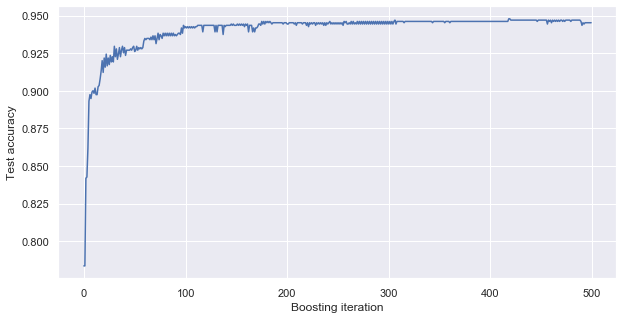

In [237]:
plt.figure(figsize=(10,5))
plt.xlabel("Boosting iteration")
plt.ylabel("Test accuracy")
sns.lineplot(range(500), test_accuracy_per_iteration)
plt.show()

The first tree we have fit (with equal observations weights) scored about 79% accuracy. Then, as the number of boosting iterations increased, the accuracy did too, albeit at a diminishing rate. After 500 iterations we hit the accuracy of almost 95%!

# Which are the best weak learners and why?

To answer this question, we first need to discuss a phenomenon called the bias-variance trade-off. To put it briefly: if predictive models are wrong, this could due to one of the following three factors:
* Bias (or underfitting) occurs when the model is not complex enough to capture relationships in the data;
* Variance (or overfitting) occurs when the model is too complex, learns the training data by heart and performs poorly on unseen data;
* Unexplainable errors that we can do nothing about.

There tends to be a trade-off between the bias and the variance in most machine learning models. That is, models suffering from high variance typically have a low bias and the other way around. **Boosting, by fitting consecutive models that focus on solving the hard cases, aims at reducing the bias. Consequently, the weak learner candidates that could benefit the most from being boosted are the ones with low variance (desired) and high bias (to be reduced in the boosting process).**

Okay, so what kind of models fulfill these criteria? What about linear regression, the most basic model one can think of? Well, by definition (and some assumptions) the ordinary least squares estimator for linear regression is unbiased, like in: the bias can be shown to be exactly zero. Hence, it is not a good candidate for being boosted.

What about decision trees? You may have noticed how we have fit out weak learner in the AdaBoost code above:

`model = DecisionTreeClassifier(max_depth=1)`

By restricting the tree's depth, we disallow it to grow complex enough to overfit the data; more than that: it cannot grow complex enough to fit the data well. That way, we have a learner that has a low variance (no capacity to overfit) and potentially high bias (too simple to capture information in the data). That's the ideal case for boosting, and we have seen how much it improved accuracy.

To verify all that's been said, let's try not restricting the tree. Let's run the same AdaBoost code with the following weak learner:

`model = DecisionTreeClassifier()`

What do we expect? Our weak learner will now be an overfitting model, i.e. - high variance, low bias. Hence, we expect to see little improvement from boosting. Here's the plot of test accuracy across boosting iterations.

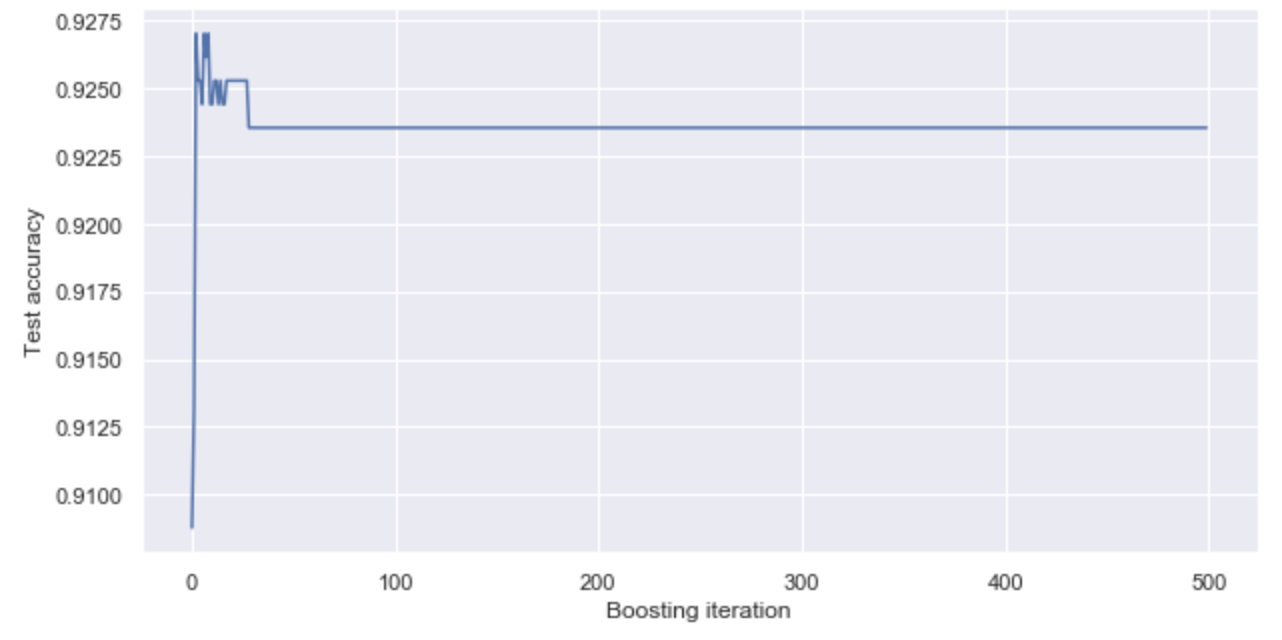

In [250]:
Image(filename="adaboost_unrestricted_tree_results.png", width=630)

Just as expected, AdaBoost boosted the accuracy of the overfitting weak learner by about 1.5 percentage points, to 92%. This occurred in the first few iterations, with no further improvement later on. Compare that with the previous scenario of a better choice of the weak learner. There, the accuracy improved by about 15 percentage points, to almost 95%.

To sum it up, we have said that good weak learners are the ones underfitting the data. Restricted trees are good, complex trees and linear regression less so. What about other low-variance, high-bias models? You could boost them too, but the trees are by far the most popular. The reasons for this are the following:
* Trees are quick to fit and scale well even as the data size grows. This is important, because in the boosting process each weak learner requires the input from the previous one to improve upon it. As a result, the models have to be fit sequentially, one cannot parallelize the computations. If a single model took long to fit, boosting many of them would take ages.
* Trees possess a number of properties that make them applicable to messy data without much need for data preprocessing. For instance, they are indifferent to the scales of respective predictors and to monotone transformations applied to them. They also automatically handle different variable types well and are robust to outliers and useless predictors by construction.

# Gradient Boosting

Gradient boosting is another boosting flavor. Similarly to adaptive boosting, it also outputs a weighted average of weak learners' predictions. The main difference is that while AdaBoost updates observation weights over iterations, gradient boosting updates the observations themselves.

The procedure is as follows. We need to start with some predictions of the training data. Since before fitting any model we have none, we simply initialize them with the target's sample mean. Then, we repeat the following multiple times. We calculate the negative gradient of the loss function with respect to the current predictions. The code below uses the gradient of the mean squared error loss, which is not optimal for binary classification, but we use it to keep things simple. Then, we fit a regression tree to these negative gradients and add the fitted values of this tree (possibly multiplied by some learning rate) to the cummulative train set predictions we have initialized at the start. As soon as the desired number of boosting iterations have been run, we can extract the final predictions. Since our target was encoded as -1 or 1, we simply take the sign of the cumulative predictions. 

The schema below outlines what happens within a single gradient boosting iteration with trees as weak learners. Hopefully, it will drive the point home.

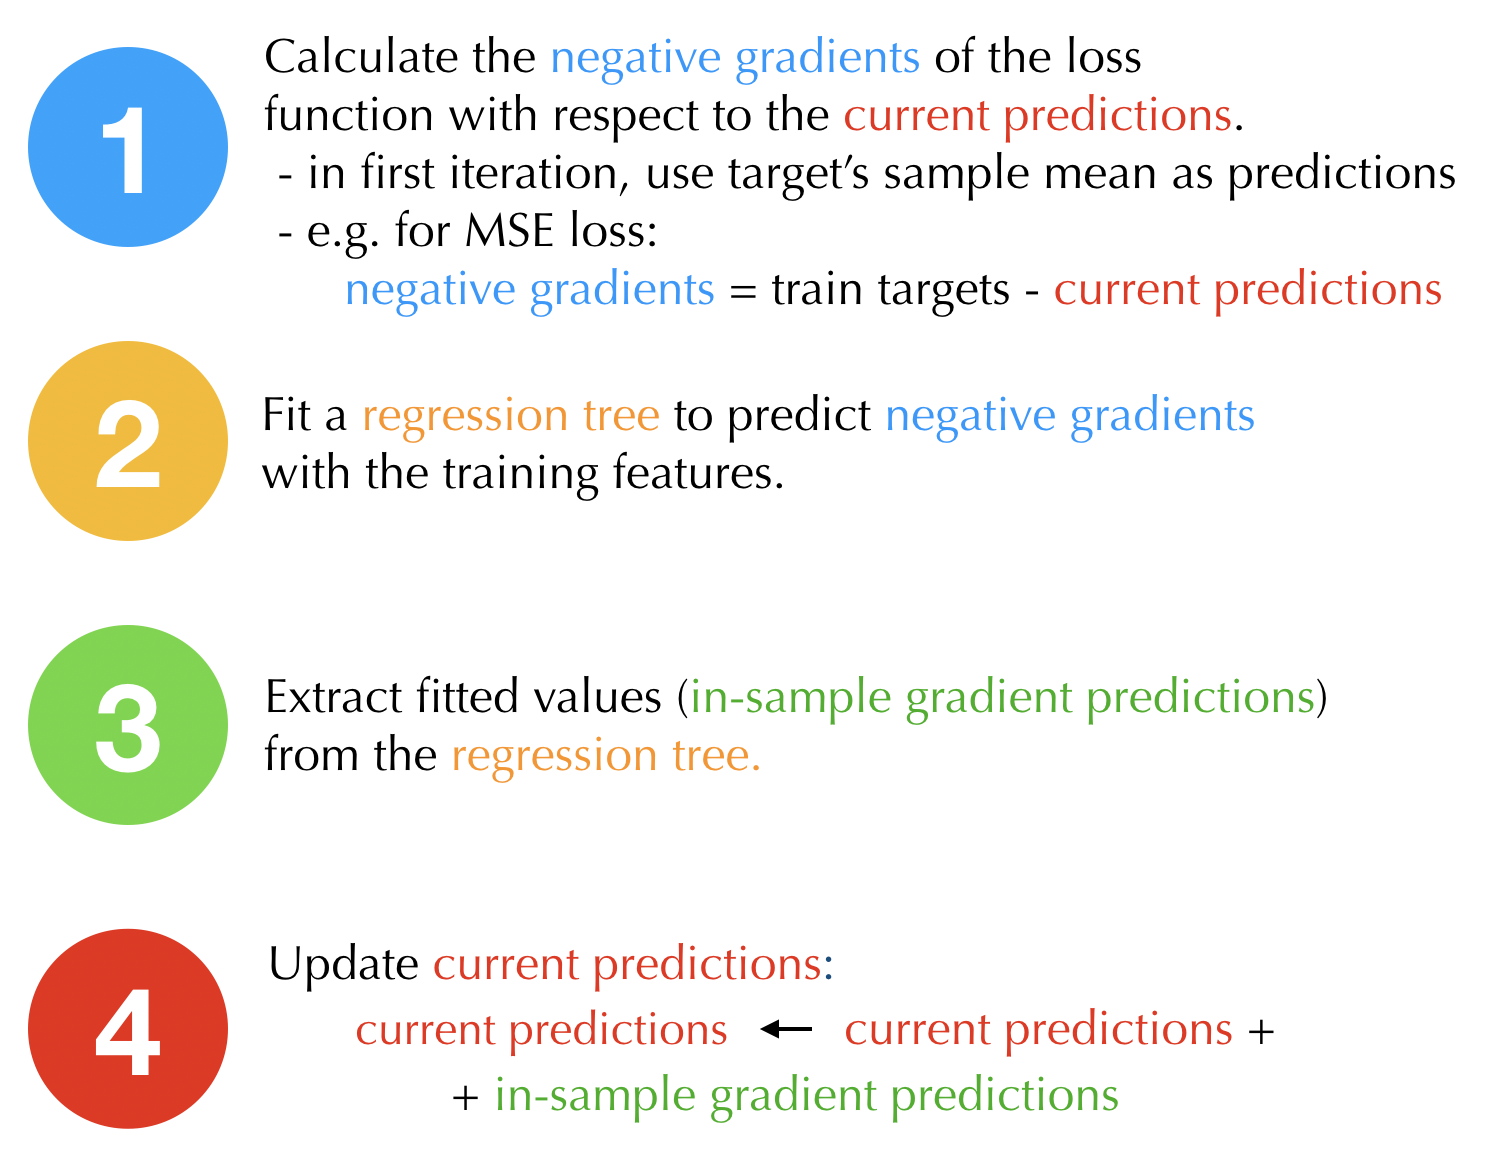

In [314]:
Image(filename='gradient_boosting_pic.png', width=700) 

Let's code it! As with the previous AdaBoost code snippet, here we also calculate the predictions for the test data on the fly, over boosting iterations, and plot the afterward.

In [309]:
# Initialize predictions-holding arrays and learning rate
train_preds = np.array([y_train.mean()] * len(y_train))
test_preds = np.zeros(shape=(len(y_test), ))
learning_rate = 1

# Loop over m boosting iterations
test_accuracy_per_iteration = []
for m in range(500):
    
    # Calculate negative gradients
    neg_gradient = y_train - train_preds
    
    # Fit a regression tree to the negative gradients
    model = DecisionTreeRegressor(max_depth=1)
    model.fit(X_train, neg_gradient)
    
    # Update in-sample predictions
    neg_gradient_preds = model.predict(X_train)
    train_preds += learning_rate * neg_gradient_preds
    
    # Evalute accuracy up to current boosting iteration on test data
    neg_gradient_test_preds = model.predict(X_test)
    test_preds += learning_rate * neg_gradient_test_preds
    test_accuracy = accuracy_score(y_test, np.sign(test_preds))
    test_accuracy_per_iteration.append(test_accuracy)
    
print(f"Final accuracy {test_accuracy}")

Final accuracy 0.9331016507384883


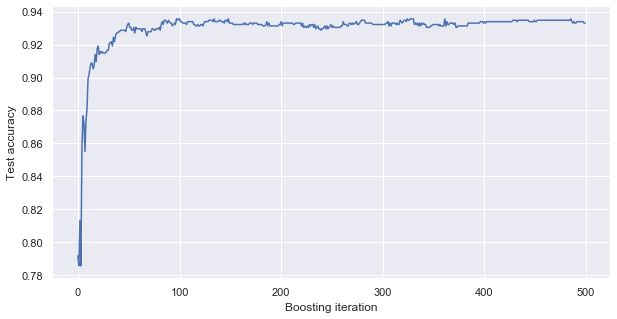

In [310]:
plt.figure(figsize=(10,5))
plt.xlabel("Boosting iteration")
plt.ylabel("Test accuracy")
sns.lineplot(range(500), test_accuracy_per_iteration)
plt.show()

We have obtained a similar accuracy to that of AdaBoost. Presumably, using a better-suited loss function the MSE would improve the results.

# Parametrizing boosting algorithms

As you might have noticed, in the gradient boosting code we have used a hyperparameter called learning rate, which we set to 1. Since it enters the equations as a multiplicative product, a value of 1 has to impact on the result. Had we set to, say, 0.1, the final accuracy would have increased by 1 percentage point. Feel free to play with it yourself!

There are many more things one can parametrize in any boosting algorithm. These parameters can then be tuned to optimize performance. Without going into too much detail, let me list some of them. This is by no means an exhaustive set.
* Learning rate: we can scale the contribution of each tree to the ensemble by a factor between 0 and 1 to avoid overfitting. This is somewhat similar in spirit to adding shrinkage in ridge regression. For smaller learning rates, we might need to increase the number of boosting iterations.
* The number of boosting iterations: too large could lead to overfitting, to small may prevent the boosting algorithm from reaching optimal performance.
* Subsampling rows: in gradient boosting models, one can fit weak learners to a bootstrap sample of data instead of to the actual data. A bootstrap sample is a sample taken with replacement from the rows of the original data. This tends to make the model generalize better.
* Subsampling columns: fitting weak learners using a random selection of feature columns in each iteration.
* All the weak learners' parameters. In the case of trees: maximum tree depth, minimum loss reduction required to make a further partition on a leaf node of the tree, and so on.

# In a nutshell

* Boosting is an esnemble technique that aggregates a number of sequentially fitted simple models called "weak learners" into a single one, the "strong learner". This combination is basically a weighted average of weak learners' predictions.
* Boosting is good at reducing bias. Hence, ideal weak learners to be boosted are those with high bias and low variance, i.e. simple, underfitting models. A popular choice are constrained tree models.
* Two main flavors of boosting are adaptive and gradient boosting.
* Adaptive boosting fits weak learners to data using sample weights. Throughout the process, the weights get updated to put more focus on the observations that are hardest to predict correctly.
* Gradient boosting fits weak learners not to the original data, but rather to the negative gradient of the loss function with respect to the current predictions. The latter get updated over iterations.
* In order to optimize the performance of boosting algorithms, one can tune multiple hyperparameters defining how weak learners learn and to what data exactly are they being fitted.

Thanks for reading! I hope you have learned something useful that will boost your projects.

# Sources

1. Hastie, T., Tibshirani, R., & Friedman, J. H. (2009). The elements of statistical learning: data mining, inference, and prediction. 2nd ed. New York: Springer.